## Import Relevant Libraries

In [3]:
import nltk

In [108]:
import pandas as pd
import nltk
from tensorflow.keras import layers
import string
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline

In [55]:
nltk.download('averaged_perceptron_tagger') #Download POS tagger
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jessica Nasayao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to C:\Users\Jessica
[nltk_data]     Nasayao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords

## Load data into a pandas dataframe

In [7]:
data = pd.read_table("recipes.csv", delimiter=";")

In [8]:
data.head()

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007


## Data processing

We want to clean the `Directions` column so that punctuations are removed and words are transformed into lowercase.

In [21]:
def clean_text(input_text):
    """
    Removes punctutations from input text and transforms the words into lowercase.
    Parameters:
    -----------
    directions_text: Input text.
    """
    cleaned_words = [n.translate(str.maketrans('', '', string.punctuation)).lower() for n in nltk.word_tokenize(input_text)]
    cleaned_input_text = " ".join(cleaned_words).strip()
    return cleaned_input_text

Apply the `clean_text` function to the `Directions` column.

In [27]:
data["Directions"] = data["Directions"].astype("str")
data["Cleaned Directions"] = data["Directions"].apply(clean_text)

In [28]:
directions = data["Cleaned Directions"].values

Apply the same function `clean_text` to the `Ingredients` column.

In [30]:
data["Ingredients"] = data["Ingredients"].astype("str")
data["Cleaned Ingredients"] = data["Ingredients"].apply(clean_text)

In [31]:
ingredients = data["Cleaned Ingredients"].values

We then tokenize both the directions and the ingredients array and convert them into token IDs (numbers) that our model can use for input. We will use the `Cleaned Directions` column as a basis for the vocabulary, assuming that all ingredients are mentioned in the directions. 

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(directions)
vocabulary = tokenizer.word_index

In [43]:
directions_sequence = tokenizer.texts_to_sequences(directions)
ingredients_sequence = tokenizer.texts_to_sequences(ingredients)

*Note: Right now, this tokenization assumes that the ingredients are all unigrams. Therefore, bigrams in the ingredients (e.g. baking soda) might not be tagged as one token, but as two separate tokens. For now this use case will suffice.*

For neural networks, we need to use equal-length input tokens. Let's visualize how long the directions are:

Text(0, 0.5, 'Frequency')

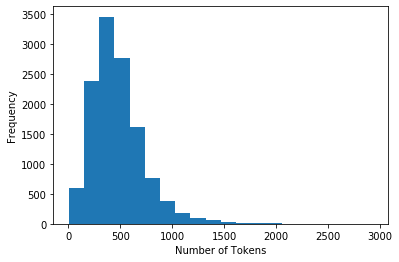

In [58]:
plt.hist([len([t for t in tokens]) for tokens in directions], bins=20)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")

Let's use 2000 as our `max_length`.

In [59]:
max_length = 2000

Now that we have identified the max length, we can pad the `directions_sequence`.

In [68]:
X = pad_sequences(maxlen=max_length, sequences=directions_sequence, padding="post", value=0)

In [69]:
X

array([[465, 582,   3, ...,   0,   0,   0],
       [ 31,  13,   5, ...,   0,   0,   0],
       [ 31,  13,   5, ...,   0,   0,   0],
       ...,
       [ 31,  13,   5, ...,   0,   0,   0],
       [ 31,  13,   5, ...,   0,   0,   0],
       [ 31,  13,   5, ...,   0,   0,   0]])

We then generate the labels based on whether a token is an ingredient or not.

In [94]:
def generate_labels(ingredients_sequence, padded_directions_sequence):
    labels = []
    for ingredients, directions in zip(ingredients_sequence, padded_directions_sequence):
        label = []
        for token in directions:
            token_is_ingredient = token in ingredients
            label.append(float(token_is_ingredient))
        labels.append(label)
    labels = np.array(labels)
    y = labels.reshape(labels.shape[0], labels.shape[1], 1)
    return y

In [95]:
y = generate_labels(ingredients_sequence, X)

We then split the model into a training set and a test set.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [101]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional


In [109]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(vocabulary), mask_zero=True, output_dim=50))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))

In [111]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [112]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          321250    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 50)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         58880     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           129       
Total params: 479,075
Trainable params: 479,075
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
 6/31 [====>.........................] - ETA: 2:31:11 - loss: 0.0282 - accuracy: 0.8220

In [ ]:
plt.plot(history.history["loss"], label="trn_loss");
plt.plot(history.history["val_loss"], label="val_loss");
plt.legend();
plt.title("Loss");

In [ ]:
plt.plot(history.history["acc"], label="trn_acc");
plt.plot(history.history["val_acc"], label="val_acc");
plt.legend();
plt.title("Accuracy");